# Fitting is an Art!

## Description
Python macro for fitting (possible) peaks (typically signal) on top of a distribution (typically background). It is an exercise in setting confidence intervals and limits (here on a possible signal). It is also an exercise in making ChiSquare (and likelihood fits) work, and get a feel for which fitting proceedure is likely to give good results.

This program contains most the necessary code for fitting with a ChiSquare. The case has been chosen carefully, and should illustrate several points. Please, _play around_ with it as much as you can.


## Your Task

The below are indicative questions, and you should end by being able to estimate the significance of your signal, and set limits on the signal size, when you don't see a significant signal.


### Authors
- Troels Petersen ([email](mailto:petersen@nbi.dk))

### Date
10th of December 2021 (latest version)

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder
# plt.close('all')

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

Ignore LogWarning (Python may complain, if it takes the log of too small numbers, e.g. log-likelihood):

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
r = np.random             # Random generator
r.seed(38)                # Set a random (but fixed) seed

In [5]:
Verbose = False
Saveplots = False
plt.rcParams.update({'font.size': 18})

### Main setting - looking for peaks or not that are there or not!

These are switches to decide, if signal should be included in the data, and also fitted for:

In [6]:
IncludeSignalInData = False
IncludeSignalInFit = False

One may want to assert, that one is not fitting for a signal, that is not there! However, in reality this is often what we actually do, to assert what the largest deviation from background is. This type of "bump hunting" can be challeging, and very common in many sciences.

---
## CASE: Possible Gaussian signal peak distribution on an exponential background:
 * $signal(x) = \frac{N_{sig}}{\sigma \sqrt{2\pi}} \cdot \exp{\left [-0.5 \cdot (\frac{x-\mu}{\sigma})^{2}\right]}$ for $x$ in [0,200]
 
 * $bkg(x) = N_{bkg} \cdot  c \cdot \exp{[-cx]}$                   for $x$ in [0,200]
---

In [7]:
# Produce signal (Gaussian peak):
Nsigx  = 50
mux    = 125.0
mux_init = mux                     # Initial value to use for the peak position in fit
sigmax =   3.0

# For signal peak of unknown position:
# mux    = r.uniform(10.0, 190.0)
# print("Real peak position: ", mux)

if IncludeSignalInData:
    x_signal = r.normal(mux, sigmax, Nsigx)
    if (Verbose) :
        print("  Signal: ", x_signal)
else:
    x_signal = []

In [8]:
# Produce background (here exponential):
Nbkgx =  25000
taux  =   80.0    # "Lifetime" of background
x_background = r.exponential(taux, Nbkgx)
if (Verbose) :
    print("  Background: ", x_background)

In [9]:
# Histogram specifications:
xmin =   0.0
xmax = 200.0
Nbins =  100       # Note that this gives the bins a natural width, and is much smaller than sigma of the signal!
binwidth = (xmax-xmin) / Nbins

In [10]:
# Note: The x_signal and x_background needs to be in a parenthesis inside the other
# parenthesis, because of the posibility of several other options.
x_data = np.concatenate((x_signal, x_background))    # Combine the two numpy arrays
if (Verbose) :
    print("  Data: ", x_data)

---
Define PDFs:
---

In [11]:
# Normalized Gaussian:
def gauss_pdf(x, mu, sigma):
    return 1.0 / np.sqrt(2 * np.pi) / np.abs(sigma) * np.exp(-(x - mu)**2 / 2.0 / sigma**2)

In [12]:
# Normalized Exponential:
def exponential_pdf(x, tau):
    return 1.0 / tau * np.exp(-x/tau)

Next we write up the full model PDF for a ChiSquare [CS] fit. You can also put one for Binned/Unbinned Likelihood [BL/UL]. They are identical, except for the normalisation, where the ChiSquare includes the bin width.

We make two versions, one which is a background fit only, and the other which includes the signal PDF in the fit function.

In [13]:
if IncludeSignalInFit:
    def PDFmodel_CS(x, Nsig, mu, sigma, Nbkg, tau) :
        return Nbkg * binwidth * exponential_pdf(x, tau) + Nsig * binwidth * gauss_pdf(x, mu, sigma)
        
    #def PDFmodel_BL(x, Nsig, mu, sigma, Nbkg, tau) :
    #    return ???
    
    #def PDFmodel_UL(x, Nsig, mu, sigma, Nbkg, tau) :
    #    return ???
    
else:
    def PDFmodel_CS(x, Nbkg, tau) :
        return Nbkg * binwidth * exponential_pdf(x, tau) 
        
    #def PDFmodel_BL(x, Nbkg, tau) :
    #    return ???
    
    #def PDFmodel_UL(x, Nbkg, tau) :
    #    return ???
    

---
Plot the data:
---

The data from the histogram is here plotted with error bars:

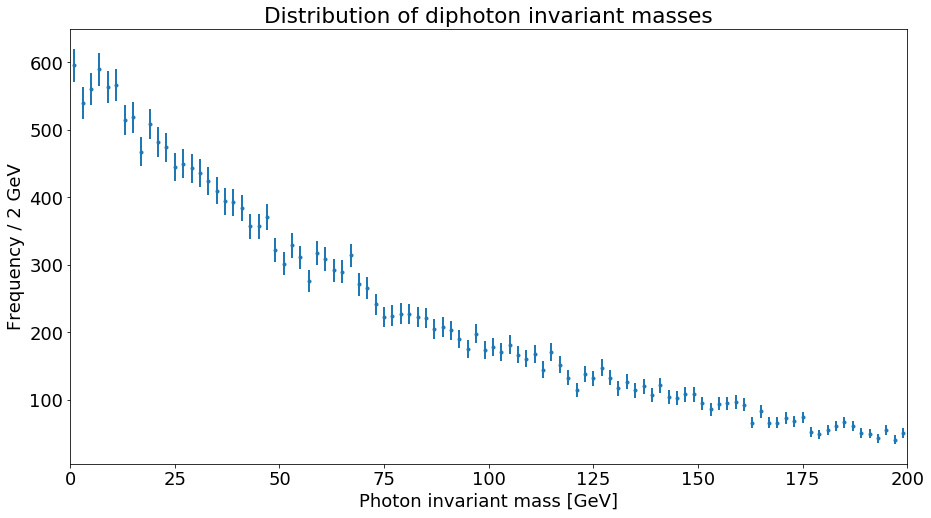

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
# For a normal histogram (without error bars) one would use:
# hist_data = ax.hist(x_data, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='Data', color='blue')
y, bin_edges = np.histogram(x_data, bins=Nbins, range=(xmin, xmax), normed=False)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)      # This is the standard for histograms - each bin is Poisson distributed!
hist_data = ax.errorbar(x, y, sy, fmt='.', linewidth=2, label="Data")
ax.set(xlabel="Photon invariant mass [GeV]", ylabel = "Frequency / {0:1.0f} GeV".format(binwidth),
       title = "Distribution of diphoton invariant masses", xlim=(xmin, xmax))
fig;

---
Fit the data:
---

NOTE: For the starting values for the fit, we could just use the values that the data was generated with!
That would of course be a great advantage. However, one of the main challenges in general fitting is to find these good starting values, which is why (really) poor ones are provided to begin with.

## $\chi^{2}$ fit:
Do the fit with a Chi2 minimisation (only using bins with entries):

In [15]:
chi2reg = Chi2Regression(PDFmodel_CS, x[y>0], y[y>0], sy[y>0])
if IncludeSignalInFit:
    minuit_cs = Minuit(chi2reg, Nsig=50.0, mu=125.0, sigma=3.0, Nbkg=5000.0, tau=80.0)
else:
    minuit_cs = Minuit(chi2reg, Nbkg=-2000.0, tau=-8.0)
minuit_cs.errordef = 1.0
minuit_cs.migrad()                                                   # Perform the actual fit
if (not minuit_cs.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

In [16]:
if IncludeSignalInFit:
    csfit_Nsig, csfit_mu, csfit_sigma, csfit_Nbkg, csfit_tau = minuit_cs.values[:]  # The fitted values of the parameters
else:
    csfit_Nbkg, csfit_tau = minuit_cs.values[:]
Chi2_value_cs = minuit_cs.fval                                             # The Chi2 value
NvarModel_cs = len(minuit_cs.values[:])
Ndof_cs = len(y[y>0]) - NvarModel_cs
ProbChi2_cs = stats.chi2.sf(Chi2_value_cs, Ndof_cs)
for name in minuit_cs.parameters:
    print("  ChiSquare Fit result: {0} = {1:.1f} +/- {2:.1f}".format(name, minuit_cs.values[name], minuit_cs.errors[name]))

  ChiSquare Fit result: Nbkg = -0.5 +/- 0.0
  ChiSquare Fit result: tau = -25.7 +/- 0.3


Plotting the result on top of the previously plotted data:
---

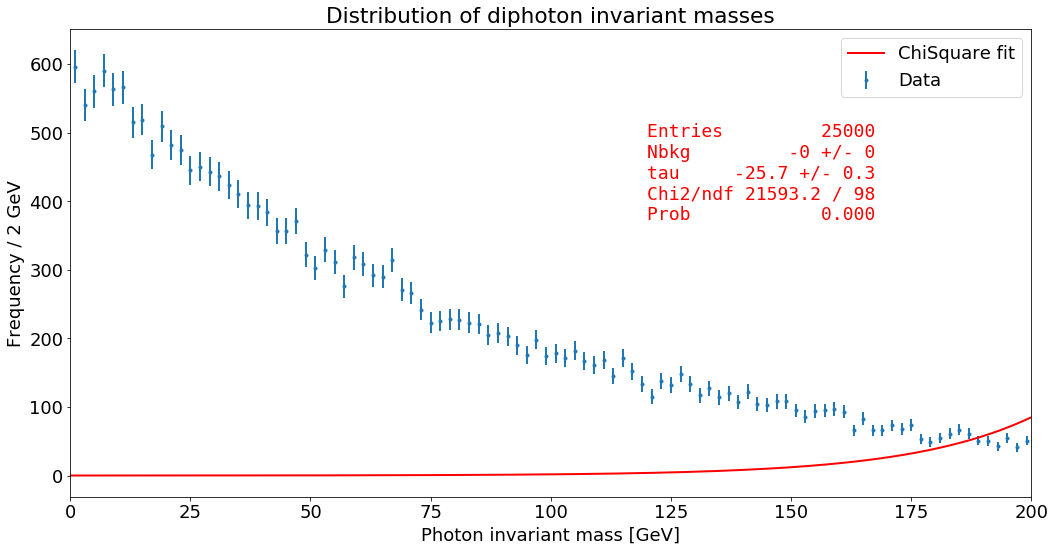

In [17]:
x_csfit = np.linspace(xmin, xmax, 1000)      # Create the x-axis for the plot of the fitted function

if IncludeSignalInFit:
    y_csfit = PDFmodel_CS(x_csfit, csfit_Nsig, csfit_mu, csfit_sigma, csfit_Nbkg, csfit_tau)
else:
    y_csfit = PDFmodel_CS(x_csfit, csfit_Nbkg, csfit_tau)

ax.plot(x_csfit, y_csfit, '-', color='red', linewidth=2, label='ChiSquare fit')

# Adding in some text (useful histogram and fit information) around the plot before showing it:
if IncludeSignalInFit:
    names = ['Entries', 'Nsig', 'mu', 'sigma', 'Nbkg', 'tau', 'Chi2/ndf', 'Prob']
    values = ["{:d}".format(len(x_data)),
              "{:.0f} +/- {:.0f}".format(minuit_cs.values['Nsig'], minuit_cs.errors['Nsig']),
              "{:.1f} +/- {:.1f}".format(minuit_cs.values['mu'], minuit_cs.errors['mu']),
              "{:.1f} +/- {:.1f}".format(minuit_cs.values['sigma'], minuit_cs.errors['sigma']),
              "{:.0f} +/- {:.0f}".format(minuit_cs.values['Nbkg'], minuit_cs.errors['Nbkg']),
              "{:.1f} +/- {:.1f}".format(minuit_cs.values['tau'], minuit_cs.errors['tau']),
              "{:.1f} / {:d}".format(Chi2_value_cs, Ndof_cs),
              "{:.3f}".format(ProbChi2_cs),
              ]
else:
    names = ['Entries', 'Nbkg', 'tau', 'Chi2/ndf', 'Prob']
    values = ["{:d}".format(len(x_data)),
              "{:.0f} +/- {:.0f}".format(minuit_cs.values['Nbkg'], minuit_cs.errors['Nbkg']),
              "{:.1f} +/- {:.1f}".format(minuit_cs.values['tau'], minuit_cs.errors['tau']),
              "{:.1f} / {:d}".format(Chi2_value_cs, Ndof_cs),
              "{:.3f}".format(ProbChi2_cs),
              ]
    
d={}
for n,v in zip(names,values):
    d[n]=v

ax.text(0.60, 0.80, nice_string_output(d, 0), family='monospace', 
        transform=ax.transAxes, fontsize=18, color='red', verticalalignment='top')

fig.tight_layout()
ax.legend()
fig

In [18]:
if Saveplots:
    fig.savefig("ExampleLikelihoodFit", dpi=600)

Questions:
---
 0. Given the data (first without signal), consider the ChiSquare fit that is provided, and see if it fits well.
    Remember to give the fit good starting values. Alternatively, see if you can write a ChiSquare fit yourself to
    match the data.
 
 
 1. Run the program without a signal peak and reasonably high statistics (as done initially).
    Is the fit good? Think about how you _quantify_ if the model is good,
    and what the value/quantity that you base it on means.
 
 
 2. Now lower the number of background events from 25000 to 250 and ask yourself the above
    questions. Would you change the fitting type, if this was your data?
    If you feel up for it, can you write an unbinned likelihood fit? Remember, that contrary to the
    ChiSquare fit, this should not include the binwidth in the normalisation of the PDF. And if you
    feel on top of things, then perhaps a binned one?


 3. Go go back to 25000 background, and switch on a signal of 50 events (i.e. "IncludeSignalInData"). 
    How confident are you, that you can see the signal in the data? Probably not! Now make the signal more clear in 
    two ways:
    1. Lower the number of background events.
    2. Increase the number of signal events.
    Do both (separately) until the point where you are certain, that you can see a peak by eye.
    Now switch on the signal fit (i.e. "IncludeSignalInFit") and consider the significance (i.e.
    the number of sigmas) of Nsig. Does the size of this correspond well with your observation?
    At how many sigmas were you "certain"?


 4. Given a "clear signal", try to give a 68% and a 95% confidence intervals on the signal parameters. This simply
    amounts to taking +- 1 and 2 uncertainties of the parameter. Following this, try to set a 95% confidence _limit_
    on a signal, that is not "clear" (e.g. where Nsig is not 2 sigma significant). This task is harder. Here, you
    should ask yourself for the size of a signal, that you would be 95% sure of discovering, and setting this as the
    limit. Don't worry, if you don't succeed on this.

    
 5. Following the above cases, now try to switch off the inclusion of a signal in your fit, and see if
    the "background-only" fit is OK despite having a "certain" peak in it! Do you still feel "certain"
    about the peak?
    
    Note by how much the ChiSquare changes. Since you introduce three new parameters in the fit, when allowing for a
    peak, your ChiSquare value should decrease, but does it decrease "enough". The rule of thumb is, that the decrease
    in chisquare ($\chi^2_{peak} - \chi^2_{no peak}$ should be chisquare distributed with Ndof equal to the differene
    in number of parameters (chisquare equivalent of Wilk's theorem).

NOTE: It is the ratio of likelihood values from the fit, which are used in a hypothesis test to determine,
which hypothesis (Null: "Background only", Alternative: "Background and Signal"), which is the most likely.
This of course requires a likelihood fit, and is then based on Wilk's theorem.
Normally, one can also simply consider the difference in Chi2 values, which in the limit of large statistics
gives the same result (as suggested above).

 6. Try to set the number of signal events to 200 and background to 25000, but choose a random location
    of the signal peak (mux) and set the initial value to say 125, i.e. pretending that you don't know, if or
    where there is a peak. See if the fit can find the position of the signal peak and hence converge correctly.
    Set the random seed to be empty (i.e. no number in the parenthesis), giving new random numbers every time,
    and see how often the fit converges on the true peak. Is a good initial value essential?


 7. Also try to remove the signal from data, and see if the fit (including signal) still "finds"
    any peaks. This is the pitfall of searching for peaks, that may very well not be there!!!


 8. Given 500 background and 20 signal events, ask yourself what helps the most to discover
    a signal peak:
     - Removing half the background below the peak.
     - Improving the resolution (sigma) by a factor two.
     
    Discuss first what you think (and why) with those around you, and then try it out with this fit.


Advanced questions:
---
 0. In general, how far can the initial parameter values stray from the true ones,
    and still find the correct signal peak and hence true minimum of the Chi2/LLH?


 1. Make a loop to repeat the fits many times, and see how the result of the
    fit compares to the true values. Which fit is least biased? And does this depend
    on the value of the input parameters?


 2. The likelihood value does not in itself tell you much. But if repeated many times
    (as above) it can be used to evaluate the fit at hand. Try to produce new data and
    fit it 1000 times, and see the distribution of likelihood values obtained... and
    then compare the "original data LLH value" with this distribution! From this, one
    can actually obtain a probability for the LLH in the same way as for the ChiSquare.
